In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [63]:
pd.set_option('future.no_silent_downcasting', True)
modeldata = pd.read_csv("/mnt/data/big_csv_files/output_csv_full.csv",low_memory=False) #load data

In [64]:
print(modeldata.head())
print(modeldata.tail())

   time_ref  account code country_code product_type        value status
0    202412  Exports   00           AD        Goods       2581.0      F
1    202412  Exports   00           AE        Goods  323384662.0      F
2    202412  Exports   00           AG        Goods     266255.0      F
3    202412  Exports   00           AI        Goods      11760.0      F
4    202412  Exports   00           AL        Goods     639168.0      F
         time_ref  account    code country_code product_type     value status
2456285    201406  Imports  A12123           US     Services  168141.0      F
2456286    201406  Imports  A12123           VN     Services  112094.0      F
2456287    201406  Imports  A12123           VU     Services   56047.0      F
2456288    201406  Imports  A12123           WS     Services   56047.0      F
2456289    201406  Imports  A12123           ZA     Services   56047.0      F


In [65]:
modeldata.info()
print(f"Dataset contains {modeldata.shape[0]} rows and {modeldata.shape[1]} columns.\n")
modeldata.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456290 entries, 0 to 2456289
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time_ref      int64  
 1   account       object 
 2   code          object 
 3   country_code  object 
 4   product_type  object 
 5   value         float64
 6   status        object 
dtypes: float64(1), int64(1), object(5)
memory usage: 131.2+ MB
Dataset contains 2456290 rows and 7 columns.



,time_ref,value
count,2.456290e+06,2.304323e+06
mean,2.019189e+05,5.096921e+06
std,3.096674e+02,1.655224e+08
min,2.014060e+05,-1.616938e+09
25%,2.016120e+05,2.384000e+03
50%,2.019090e+05,2.205900e+04
75%,2.022060e+05,1.966490e+05
max,2.024120e+05,2.409993e+10


In [ ]:
#only time_ref and value are scalars whose numbers represent discrete values. The rest are codes where there is no numerical values, meaning that they can be encoded.
#there is no order or relationship between code values, meaning they are candidates for hotcoding.
#however if there are too many unique values than hotcoding is not viable

In [66]:
#first check for null values. For discrete columns, median will be used. For label columns a random label will be used.
print(modeldata.isnull().sum())

time_ref             0
account              0
code                 0
country_code      1578
product_type         0
value           151967
status               0
dtype: int64


In [67]:
modeldata['value'] = modeldata['value'].fillna(modeldata['value'].median()) # median
modeldata['country_code'] = modeldata['country_code'].fillna('ZZ') # ZZ is the value for unknown country code

In [68]:
print(modeldata.isnull().sum())

time_ref        0
account         0
code            0
country_code    0
product_type    0
value           0
status          0
dtype: int64


In [69]:
print(modeldata['code'].describe()) #1407 unique values. Cannot be hotcoded

count     2456290
unique       1407
top            00
freq        17915
Name: code, dtype: object


In [70]:
print(modeldata['country_code'].describe()) #251 unique values. Cannot be hotcoded

count     2456290
unique        252
top            AU
freq        93778
Name: country_code, dtype: object


In [71]:
print(modeldata['account'].describe()) #2 unique values. Can be hot coded

count     2456290
unique          2
top       Imports
freq      1400991
Name: account, dtype: object


In [72]:
print(modeldata['product_type'].describe()) #2 unique values. Can be hot coded

count     2456290
unique          2
top         Goods
freq      2179965
Name: product_type, dtype: object


In [73]:
print(modeldata['status'].describe()) #3 unique values. Can be hot coded

count     2456290
unique          3
top             F
freq      2282345
Name: status, dtype: object


In [74]:
modeldata = pd.get_dummies(modeldata, columns=['account'], drop_first=True)  #encode account one hot
modeldata = pd.get_dummies(modeldata, columns=['product_type'], drop_first=True)  #encode product_type one hot
modeldata = pd.get_dummies(modeldata, columns=['status'], drop_first=True) #encode status one hot

In [75]:
modeldata

,time_ref,code,country_code,value,account_Imports,product_type_Services,status_F,status_R
0,202412,00,AD,2581.0,False,False,True,False
1,202412,00,AE,323384662.0,False,False,True,False
2,202412,00,AG,266255.0,False,False,True,False
3,202412,00,AI,11760.0,False,False,True,False
4,202412,00,AL,639168.0,False,False,True,False
...,...,...,...,...,...,...,...,...
2456285,201406,A12123,US,168141.0,True,True,True,False
2456286,201406,A12123,VN,112094.0,True,True,True,False
2456287,201406,A12123,VU,56047.0,True,True,True,False
2456288,201406,A12123,WS,56047.0,True,True,True,False


In [76]:
modeldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456290 entries, 0 to 2456289
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   time_ref               int64  
 1   code                   object 
 2   country_code           object 
 3   value                  float64
 4   account_Imports        bool   
 5   product_type_Services  bool   
 6   status_F               bool   
 7   status_R               bool   
dtypes: bool(4), float64(1), int64(1), object(2)
memory usage: 84.3+ MB


In [77]:
y = modeldata['value'] # the column that we are attempting to predict

In [78]:
X = modeldata[['time_ref', 'account_Imports', 'product_type_Services', 'status_F', 'status_R']] # features used to predict
#will exclude code and country_code objects that were not suitable for hot coding

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split into training and testing sets

In [80]:
# Create an instance of the LinearRegression model
model = LinearRegression()

In [81]:
# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [82]:
y_pred = model.predict(X_test)

In [85]:
# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared value
r_squared = r2_score(y_test, y_pred)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared Value: {r_squared}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 2.906288162331227e+16
R-squared Value: 0.0019545326225943738
Mean Absolute Error (MAE): 8555135.90352871


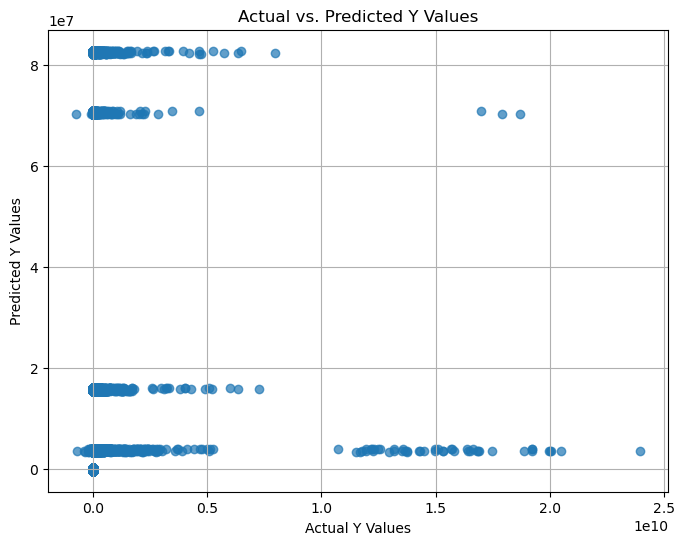

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Y Values")
plt.ylabel("Predicted Y Values")
plt.title("Actual vs. Predicted Y Values")
plt.grid(True)
plt.show()